<a href="https://colab.research.google.com/github/ruorong/classifcation/blob/main/classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import time
import random
import datetime
import sklearn

In [ ]:
tf.__version__

'2.6.0'

In [5]:
!git clone https://github.com/ruorong/classifcation.git

Cloning into 'classifcation'...
remote: Enumerating objects: 2541, done.
remote: Counting objects: 100% (2541/2541), done.
remote: Compressing objects: 100% (2540/2540), done.
remote: Total 2541 (delta 2), reused 2534 (delta 0), pack-reused 0
Receiving objects: 100% (2541/2541), 92.71 MiB | 32.19 MiB/s, done.
Resolving deltas: 100% (2/2), done.


# 数据增强

In [ ]:
start = datetime.datetime.now()
for dirs in glob.glob("./pokemanpicture/*"):
    paths = glob.glob(dirs + "/*")
    
    for path in :
        img = tf.keras.preprocessing.image.load_img(path)
        img = np.array(img) # 转化为 ndarray的形式
        img = tf.image.adjust_brightness(img,0.3)
        temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
        tf.keras.preprocessing.image.save_img(temp,img)
    for path in :
        img = tf.keras.preprocessing.image.load_img(path)
        img = np.array(img) # 转化为 ndarray的形式
        img = tf.image.flip_left_right(img)
        temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
        tf.keras.preprocessing.image.save_img(temp,img)
end = datetime.datetime.now()
print(end-start)

In [ ]:
start = datetime.datetime.now()
for dirs in glob.glob("./pokemanpicture/*"):
    flag = 1
    for path in glob.glob(dirs + "/*"):
        img = tf.keras.preprocessing.image.load_img(path)
        img = np.array(img) # 转化为 ndarray的形式
        img = tf.image.adjust_brightness(img,0.3)
        temp = os.path.dirname(path) + "/" + str(time.time()) + ".png"
        tf.keras.preprocessing.image.save_img(temp,img)
        if flag:
            print(temp)
            flag = 0
end = datetime.datetime.now()
print(end-start)

./pokemanpicture/mewtwo/1634297470.5968313.png


/home/long/.conda/envs/long/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


./pokemanpicture/charmander/1634297539.8135343.png
./pokemanpicture/squirtle/1634297615.9221616.png
./pokemanpicture/bulbasaur/1634297672.387268.png
./pokemanpicture/pikachu/1634297737.1577804.png
0:05:30.447628


# 划分数据集

In [ ]:
images = []
labels = []
name2label = dict()

t = 0
for dirs in glob.glob("./pokemanpicture/*"):
    name = dirs.split("/")[2]
    name2label[name] = t
    t += 1
    for path in glob.glob(dirs + "/*"):
        images.append(path)
random.shuffle(images)
for path in images:
    name = path.split("/")[2]
    labels.append(name2label[name])

df = pd.DataFrame({"images":images,"labels":labels})
df.to_csv("./image.csv",index=False)
print(name2label)
df.head()

{'mewtwo': 0, 'charmander': 1, 'squirtle': 2, 'bulbasaur': 3, 'pikachu': 4}


,images,labels
0,./pokemanpicture/mewtwo/1634297486.2058926.png,0
1,./pokemanpicture/squirtle/1634297617.1559815.png,2
2,./pokemanpicture/pikachu/00000129.jpg,4
3,./pokemanpicture/mewtwo/1634297521.554187.png,0
4,./pokemanpicture/pikachu/00000057.png,4


In [ ]:
def load_data(model):
    df = pd.read_csv("./image.csv")
    images = df["images"]
    labels = df["labels"]
    if model == "train":
        print("训练集：" + str(len(labels[:int(0.7*len(labels))])))
        return images[:int(0.7*len(images))], labels[:int(0.7*len(labels))]
    elif model == "val":
        print("验证集：" + str(len(labels[int(0.7*len(labels)):])))
        return images[int(0.7*len(images)):], labels[int(0.7*len(labels)):]

# 数据预处理并放入tf.data中

In [ ]:
x = tf.io.read_file("./pokemanpicture/bulbasaur/00000000.png")
x = tf.io.decode_jpeg(x,channels=3)
print(x.shape,x.dtype)
x = tf.image.resize(x,(244,244))
x = tf.cast(x,dtype=tf.float32) / 255.

(900, 900, 3) <dtype: 'uint8'>


In [ ]:
def preprocess(x,y):
    x = tf.io.read_file(x)
    x = tf.io.decode_jpeg(x,channels=3)
    x = tf.image.resize(x,(224,224))
    x = tf.cast(x,dtype=tf.float32) / 255.
    
    y = tf.convert_to_tensor(y)
    y = tf.one_hot(y,depth=5)
    return x,y

In [ ]:
batch_size = 8
train_data = tf.data.Dataset.from_tensor_slices(load_data("train"))
train_data = train_data.shuffle(1000).map(preprocess).batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices(load_data("val"))
val_data = val_data.map(preprocess).batch(batch_size)  # 不能shuffle 不然后面混淆矩阵找不到真是标签

print(train_data)
print(val_data)

训练集：1615
验证集：693
<BatchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>


# 构建模型

In [ ]:
base_model = tf.keras.applications.vgg16.VGG16(weights="./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",include_top=False)

for layer in base_model.layers[:-4]:
    layer.trainable = False
# base_model.summary()
  
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(256,activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5,activation="softmax"))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 1285      
Total params: 14,847,301
Trainable params: 7,212,037
Non-trainable params: 7,635,264
_________________________________________________________________


# 模型编译和训练

In [ ]:
easystop = tf.keras.callbacks.EarlyStopping(patience=3,min_delta=0.01)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
start = datetime.datetime.now()
history = model.fit(train_data,validation_data=val_data,callbacks=[easystop],epochs=200)
end = datetime.datetime.now()
print("*"*100)
print(end - start)

Epoch 1/200
     16/Unknown - 11s 701ms/step - loss: 1.6051 - accuracy: 0.2188

2021-10-15 21:07:17.258550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


     34/Unknown - 23s 667ms/step - loss: 1.5498 - accuracy: 0.3272

2021-10-15 21:07:28.634847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


     37/Unknown - 25s 664ms/step - loss: 1.5397 - accuracy: 0.3378

2021-10-15 21:07:30.611033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: bKGD: invalid
2021-10-15 21:07:30.620771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


     55/Unknown - 36s 663ms/step - loss: 1.4615 - accuracy: 0.4364

2021-10-15 21:07:42.416330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


     64/Unknown - 43s 668ms/step - loss: 1.4299 - accuracy: 0.4648

2021-10-15 21:07:48.716662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


     75/Unknown - 49s 660ms/step - loss: 1.4001 - accuracy: 0.5000

2021-10-15 21:07:55.505294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


     77/Unknown - 51s 661ms/step - loss: 1.3984 - accuracy: 0.5016

2021-10-15 21:07:57.150567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


     84/Unknown - 55s 658ms/step - loss: 1.3868 - accuracy: 0.5119

2021-10-15 21:08:01.289641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


     87/Unknown - 57s 656ms/step - loss: 1.3808 - accuracy: 0.5187

2021-10-15 21:08:03.020282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:08:03.020340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


     91/Unknown - 60s 654ms/step - loss: 1.3655 - accuracy: 0.5357

2021-10-15 21:08:05.496545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


     95/Unknown - 62s 652ms/step - loss: 1.3541 - accuracy: 0.5500

2021-10-15 21:08:08.038494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    109/Unknown - 71s 648ms/step - loss: 1.3204 - accuracy: 0.5849

2021-10-15 21:08:16.717571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    111/Unknown - 72s 648ms/step - loss: 1.3175 - accuracy: 0.5878

2021-10-15 21:08:17.845769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    112/Unknown - 73s 647ms/step - loss: 1.3156 - accuracy: 0.5893

2021-10-15 21:08:18.511939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    119/Unknown - 77s 647ms/step - loss: 1.3030 - accuracy: 0.6029

2021-10-15 21:08:22.988905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    120/Unknown - 78s 647ms/step - loss: 1.3026 - accuracy: 0.6031

2021-10-15 21:08:23.646694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    122/Unknown - 79s 646ms/step - loss: 1.2991 - accuracy: 0.6055

2021-10-15 21:08:24.801256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:08:24.801444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


    133/Unknown - 86s 643ms/step - loss: 1.2828 - accuracy: 0.6212

2021-10-15 21:08:31.626517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    146/Unknown - 93s 640ms/step - loss: 1.2648 - accuracy: 0.6421

2021-10-15 21:08:39.458275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:08:39.458319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


    149/Unknown - 95s 639ms/step - loss: 1.2602 - accuracy: 0.6460

2021-10-15 21:08:41.169443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    151/Unknown - 96s 639ms/step - loss: 1.2589 - accuracy: 0.6474

2021-10-15 21:08:42.470836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    167/Unknown - 106s 635ms/step - loss: 1.2332 - accuracy: 0.6737

2021-10-15 21:08:52.027149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    169/Unknown - 107s 635ms/step - loss: 1.2301 - accuracy: 0.6768

2021-10-15 21:08:53.249674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    179/Unknown - 113s 633ms/step - loss: 1.2156 - accuracy: 0.6934

2021-10-15 21:08:59.449839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


    202/Unknown - 127s 629ms/step - loss: 1.1983 - accuracy: 0.7084

2021-10-15 21:09:12.963770: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2021-10-15 21:09:13.712142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:09:16.486865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:09:17.939556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:09:22.198364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:09:27.218198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:09:27.393570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:09:33.469320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profil

202/202 [==============================] - 169s 838ms/step - loss: 1.1983 - accuracy: 0.7084 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/200


2021-10-15 21:09:55.356419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:09:55.356455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


 10/202 [>.............................] - ETA: 1:59 - loss: 0.9676 - accuracy: 0.9375

2021-10-15 21:10:01.662680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/202 [=>............................] - ETA: 1:55 - loss: 0.9792 - accuracy: 0.9297

2021-10-15 21:10:05.160673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/202 [===>..........................] - ETA: 1:47 - loss: 0.9678 - accuracy: 0.9444

2021-10-15 21:10:11.932550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/202 [===>..........................] - ETA: 1:44 - loss: 0.9748 - accuracy: 0.9375

2021-10-15 21:10:14.992161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:10:14.992234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


 35/202 [====>.........................] - ETA: 1:42 - loss: 0.9790 - accuracy: 0.9321

2021-10-15 21:10:16.797060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/202 [=====>........................] - ETA: 1:38 - loss: 0.9765 - accuracy: 0.9329

2021-10-15 21:10:20.448186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/202 [======>.......................] - ETA: 1:32 - loss: 0.9708 - accuracy: 0.9423

2021-10-15 21:10:27.268415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/202 [======>.......................] - ETA: 1:31 - loss: 0.9704 - accuracy: 0.9434

2021-10-15 21:10:27.979944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/202 [=======>......................] - ETA: 1:29 - loss: 0.9684 - accuracy: 0.9442

2021-10-15 21:10:29.796555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:10:29.807728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: bKGD: invalid


 68/202 [=========>....................] - ETA: 1:22 - loss: 0.9624 - accuracy: 0.9504

2021-10-15 21:10:37.261416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/202 [===============>..............] - ETA: 54s - loss: 0.9619 - accuracy: 0.9496

2021-10-15 21:11:05.693299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/202 [================>.............] - ETA: 52s - loss: 0.9670 - accuracy: 0.9444

2021-10-15 21:11:07.660125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/202 [================>.............] - ETA: 51s - loss: 0.9679 - accuracy: 0.9439

2021-10-15 21:11:08.134717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/202 [=================>............] - ETA: 47s - loss: 0.9728 - accuracy: 0.9390

2021-10-15 21:11:12.435563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/202 [==================>...........] - ETA: 45s - loss: 0.9718 - accuracy: 0.9404

2021-10-15 21:11:14.295214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:11:14.331718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/202 [====================>.........] - ETA: 35s - loss: 0.9694 - accuracy: 0.9431

2021-10-15 21:11:24.657958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/202 [=====================>........] - ETA: 29s - loss: 0.9689 - accuracy: 0.9432

2021-10-15 21:11:30.532863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/202 [======================>.......] - ETA: 29s - loss: 0.9686 - accuracy: 0.9435

2021-10-15 21:11:31.002716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/202 [=======================>......] - ETA: 24s - loss: 0.9696 - accuracy: 0.9421

2021-10-15 21:11:35.460172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/202 [========================>.....] - ETA: 19s - loss: 0.9692 - accuracy: 0.9423

2021-10-15 21:11:41.478722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/202 [=========================>....] - ETA: 13s - loss: 0.9712 - accuracy: 0.9406

2021-10-15 21:11:48.038703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:11:48.038756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


196/202 [============================>.] - ETA: 3s - loss: 0.9752 - accuracy: 0.9349

2021-10-15 21:11:57.204170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/202 [============================>.] - ETA: 0s - loss: 0.9795 - accuracy: 0.9303

2021-10-15 21:12:00.831749: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2021-10-15 21:12:01.452620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:12:04.421013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:12:05.977166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:12:10.307845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:12:15.484183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:12:15.689180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:12:22.303456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profil

202/202 [==============================] - 167s 828ms/step - loss: 0.9795 - accuracy: 0.9300 - val_loss: 1.0239 - val_accuracy: 0.8788
Epoch 3/200


2021-10-15 21:12:42.639351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:12:42.715125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/202 [..............................] - ETA: 2:32 - loss: 0.9509 - accuracy: 1.0000

2021-10-15 21:12:43.389342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/202 [>.............................] - ETA: 2:01 - loss: 0.9633 - accuracy: 0.9432

2021-10-15 21:12:49.654752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/202 [==>...........................] - ETA: 1:51 - loss: 0.9533 - accuracy: 0.9620

2021-10-15 21:12:57.141159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/202 [==>...........................] - ETA: 1:50 - loss: 0.9565 - accuracy: 0.9600

2021-10-15 21:12:58.311509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:12:58.311570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


 35/202 [====>.........................] - ETA: 1:43 - loss: 0.9484 - accuracy: 0.9679

2021-10-15 21:13:04.433400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/202 [====>.........................] - ETA: 1:43 - loss: 0.9473 - accuracy: 0.9688

2021-10-15 21:13:05.130263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: bKGD: invalid


 55/202 [=======>......................] - ETA: 1:31 - loss: 0.9539 - accuracy: 0.9568

2021-10-15 21:13:16.706765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/202 [=======>......................] - ETA: 1:30 - loss: 0.9564 - accuracy: 0.9554

2021-10-15 21:13:17.474822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:13:17.475119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


102/202 [==============>...............] - ETA: 1:01 - loss: 0.9538 - accuracy: 0.9547

2021-10-15 21:13:45.483368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/202 [==============>...............] - ETA: 59s - loss: 0.9538 - accuracy: 0.9548 

2021-10-15 21:13:47.268666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/202 [================>.............] - ETA: 53s - loss: 0.9525 - accuracy: 0.9565

2021-10-15 21:13:53.704440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/202 [================>.............] - ETA: 50s - loss: 0.9539 - accuracy: 0.9552

2021-10-15 21:13:56.779549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/202 [=================>............] - ETA: 47s - loss: 0.9533 - accuracy: 0.9560

2021-10-15 21:13:59.746170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/202 [=================>............] - ETA: 46s - loss: 0.9526 - accuracy: 0.9567

2021-10-15 21:14:00.957244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:14:00.957311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


137/202 [===================>..........] - ETA: 40s - loss: 0.9506 - accuracy: 0.9580

2021-10-15 21:14:07.264609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/202 [===================>..........] - ETA: 38s - loss: 0.9499 - accuracy: 0.9586

2021-10-15 21:14:08.497143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/202 [====================>.........] - ETA: 33s - loss: 0.9555 - accuracy: 0.9524

2021-10-15 21:14:13.261445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/202 [=====================>........] - ETA: 32s - loss: 0.9565 - accuracy: 0.9513

2021-10-15 21:14:14.640389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/202 [======================>.......] - ETA: 28s - loss: 0.9568 - accuracy: 0.9511

2021-10-15 21:14:18.924485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/202 [======================>.......] - ETA: 25s - loss: 0.9575 - accuracy: 0.9508

2021-10-15 21:14:21.424912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/202 [=======================>......] - ETA: 23s - loss: 0.9576 - accuracy: 0.9505

2021-10-15 21:14:23.809581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/202 [=======================>......] - ETA: 22s - loss: 0.9577 - accuracy: 0.9503

2021-10-15 21:14:25.079788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/202 [===========================>..] - ETA: 8s - loss: 0.9586 - accuracy: 0.9497

2021-10-15 21:14:39.337590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/202 [============================>.] - ETA: 0s - loss: 0.9599 - accuracy: 0.9478

2021-10-15 21:14:47.370806: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2021-10-15 21:14:47.980439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:14:50.892362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:14:52.416908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:14:56.907556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:15:02.149394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:15:02.356116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:15:09.076312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profil

202/202 [==============================] - 167s 827ms/step - loss: 0.9599 - accuracy: 0.9480 - val_loss: 1.0064 - val_accuracy: 0.8975
Epoch 4/200
  9/202 [>.............................] - ETA: 2:06 - loss: 1.0890 - accuracy: 0.8194

2021-10-15 21:15:35.588117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/202 [===>..........................] - ETA: 1:54 - loss: 1.0070 - accuracy: 0.8935

2021-10-15 21:15:47.392890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: bKGD: invalid


 32/202 [===>..........................] - ETA: 1:50 - loss: 0.9945 - accuracy: 0.9062

2021-10-15 21:15:50.478437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/202 [====>.........................] - ETA: 1:47 - loss: 0.9812 - accuracy: 0.9219

2021-10-15 21:15:56.540604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/202 [======>.......................] - ETA: 1:40 - loss: 0.9719 - accuracy: 0.9325

2021-10-15 21:16:02.634725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/202 [======>.......................] - ETA: 1:37 - loss: 0.9682 - accuracy: 0.9363

2021-10-15 21:16:04.606516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/202 [=======>......................] - ETA: 1:34 - loss: 0.9632 - accuracy: 0.9428

2021-10-15 21:16:08.444855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/202 [=========>....................] - ETA: 1:26 - loss: 0.9604 - accuracy: 0.9437

2021-10-15 21:16:16.299399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:16:16.299452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


 72/202 [=========>....................] - ETA: 1:25 - loss: 0.9604 - accuracy: 0.9427

2021-10-15 21:16:16.973119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/202 [===========>..................] - ETA: 1:17 - loss: 0.9603 - accuracy: 0.9443

2021-10-15 21:16:23.902851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/202 [===========>..................] - ETA: 1:16 - loss: 0.9612 - accuracy: 0.9441

2021-10-15 21:16:25.160420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/202 [===========>..................] - ETA: 1:15 - loss: 0.9602 - accuracy: 0.9454

2021-10-15 21:16:26.429054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/202 [============>.................] - ETA: 1:11 - loss: 0.9580 - accuracy: 0.9484

2021-10-15 21:16:29.557445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/202 [=============>................] - ETA: 1:09 - loss: 0.9568 - accuracy: 0.9500

2021-10-15 21:16:31.410578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/202 [==============>...............] - ETA: 1:02 - loss: 0.9557 - accuracy: 0.9493

2021-10-15 21:16:38.406156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/202 [===============>..............] - ETA: 1:00 - loss: 0.9562 - accuracy: 0.9491

2021-10-15 21:16:39.623678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/202 [===============>..............] - ETA: 1:00 - loss: 0.9562 - accuracy: 0.9495

2021-10-15 21:16:40.428748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/202 [================>.............] - ETA: 53s - loss: 0.9551 - accuracy: 0.9506

2021-10-15 21:16:46.593839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:16:46.593929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


126/202 [=================>............] - ETA: 49s - loss: 0.9535 - accuracy: 0.9524

2021-10-15 21:16:50.942928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/202 [==================>...........] - ETA: 43s - loss: 0.9554 - accuracy: 0.9506

2021-10-15 21:16:56.059993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/202 [====================>.........] - ETA: 36s - loss: 0.9538 - accuracy: 0.9526

2021-10-15 21:17:02.837220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/202 [=======================>......] - ETA: 25s - loss: 0.9505 - accuracy: 0.9560

2021-10-15 21:17:13.258550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:17:13.258608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


167/202 [=======================>......] - ETA: 22s - loss: 0.9492 - accuracy: 0.9573

2021-10-15 21:17:16.327174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/202 [==========================>...] - ETA: 11s - loss: 0.9473 - accuracy: 0.9592

2021-10-15 21:17:27.026710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/202 [============================>.] - ETA: 1s - loss: 0.9473 - accuracy: 0.9598

2021-10-15 21:17:36.204583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/202 [============================>.] - ETA: 0s - loss: 0.9468 - accuracy: 0.9602

2021-10-15 21:17:37.871102: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2021-10-15 21:17:38.509838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:17:41.414517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:17:42.904717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:17:47.300513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:17:52.663411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:17:52.858772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:17:59.592752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profil

202/202 [==============================] - 171s 849ms/step - loss: 0.9468 - accuracy: 0.9604 - val_loss: 0.9294 - val_accuracy: 0.9740
Epoch 5/200
 38/202 [====>.........................] - ETA: 1:44 - loss: 0.9291 - accuracy: 0.9770

2021-10-15 21:18:45.193704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/202 [=====>........................] - ETA: 1:41 - loss: 0.9268 - accuracy: 0.9792

2021-10-15 21:18:47.849702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/202 [========>.....................] - ETA: 1:29 - loss: 0.9284 - accuracy: 0.9775

2021-10-15 21:18:59.667992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/202 [========>.....................] - ETA: 1:28 - loss: 0.9277 - accuracy: 0.9782

2021-10-15 21:19:01.054736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/202 [=========>....................] - ETA: 1:24 - loss: 0.9292 - accuracy: 0.9761

2021-10-15 21:19:04.182448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: bKGD: invalid


 82/202 [===========>..................] - ETA: 1:15 - loss: 0.9319 - accuracy: 0.9726

2021-10-15 21:19:12.786520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/202 [===========>..................] - ETA: 1:13 - loss: 0.9332 - accuracy: 0.9721

2021-10-15 21:19:14.584407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/202 [=============>................] - ETA: 1:07 - loss: 0.9334 - accuracy: 0.9711

2021-10-15 21:19:20.910642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:19:20.910674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


 97/202 [=============>................] - ETA: 1:05 - loss: 0.9341 - accuracy: 0.9704

2021-10-15 21:19:22.066992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/202 [=============>................] - ETA: 1:04 - loss: 0.9337 - accuracy: 0.9710

2021-10-15 21:19:23.403853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/202 [==============>...............] - ETA: 1:02 - loss: 0.9339 - accuracy: 0.9706

2021-10-15 21:19:25.196744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/202 [================>.............] - ETA: 51s - loss: 0.9337 - accuracy: 0.9706

2021-10-15 21:19:35.777800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/202 [=================>............] - ETA: 48s - loss: 0.9352 - accuracy: 0.9690

2021-10-15 21:19:39.426698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/202 [==================>...........] - ETA: 45s - loss: 0.9351 - accuracy: 0.9692

2021-10-15 21:19:42.518899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:19:42.678448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/202 [==================>...........] - ETA: 43s - loss: 0.9354 - accuracy: 0.9690

2021-10-15 21:19:44.359091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:19:44.359155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


147/202 [====================>.........] - ETA: 34s - loss: 0.9336 - accuracy: 0.9711

2021-10-15 21:19:53.551190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/202 [=======================>......] - ETA: 25s - loss: 0.9341 - accuracy: 0.9707

2021-10-15 21:20:02.793790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/202 [=========================>....] - ETA: 15s - loss: 0.9347 - accuracy: 0.9703

2021-10-15 21:20:12.350847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:20:12.350885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


187/202 [==========================>...] - ETA: 9s - loss: 0.9358 - accuracy: 0.9699 

2021-10-15 21:20:18.421782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:20:18.458835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/202 [===========================>..] - ETA: 5s - loss: 0.9350 - accuracy: 0.9709

2021-10-15 21:20:22.254794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/202 [===========================>..] - ETA: 5s - loss: 0.9349 - accuracy: 0.9710

2021-10-15 21:20:22.846312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/202 [============================>.] - ETA: 3s - loss: 0.9346 - accuracy: 0.9713

2021-10-15 21:20:24.160758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/202 [============================>.] - ETA: 3s - loss: 0.9344 - accuracy: 0.9714

2021-10-15 21:20:24.669341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/202 [============================>.] - ETA: 0s - loss: 0.9353 - accuracy: 0.9708

2021-10-15 21:20:27.631654: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2021-10-15 21:20:28.245582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:20:31.184660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:20:32.720240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:20:37.144260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:20:42.575754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:20:42.788970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:20:49.740410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profil

202/202 [==============================] - 170s 841ms/step - loss: 0.9353 - accuracy: 0.9709 - val_loss: 0.9368 - val_accuracy: 0.9668
Epoch 6/200
  7/202 [>.............................] - ETA: 2:10 - loss: 0.9361 - accuracy: 0.9821

2021-10-15 21:21:15.694076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/202 [==>...........................] - ETA: 1:56 - loss: 0.9407 - accuracy: 0.9643

2021-10-15 21:21:24.512856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:21:24.512903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


 23/202 [==>...........................] - ETA: 1:55 - loss: 0.9416 - accuracy: 0.9620

2021-10-15 21:21:25.856430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/202 [==>...........................] - ETA: 1:53 - loss: 0.9387 - accuracy: 0.9650

2021-10-15 21:21:27.008860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/202 [===>..........................] - ETA: 1:51 - loss: 0.9351 - accuracy: 0.9688

2021-10-15 21:21:28.902500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:21:28.979881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/202 [===>..........................] - ETA: 1:49 - loss: 0.9322 - accuracy: 0.9718

2021-10-15 21:21:30.744930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/202 [====>.........................] - ETA: 1:46 - loss: 0.9338 - accuracy: 0.9688

2021-10-15 21:21:34.042949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:21:34.092933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/202 [=======>......................] - ETA: 1:33 - loss: 0.9321 - accuracy: 0.9705

2021-10-15 21:21:46.055725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/202 [========>.....................] - ETA: 1:29 - loss: 0.9294 - accuracy: 0.9734

2021-10-15 21:21:49.906687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/202 [========>.....................] - ETA: 1:28 - loss: 0.9290 - accuracy: 0.9738

2021-10-15 21:21:50.430763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/202 [=========>....................] - ETA: 1:23 - loss: 0.9288 - accuracy: 0.9732

2021-10-15 21:21:55.320364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: bKGD: invalid


 78/202 [==========>...................] - ETA: 1:18 - loss: 0.9272 - accuracy: 0.9760

2021-10-15 21:22:00.417690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/202 [=============>................] - ETA: 1:07 - loss: 0.9274 - accuracy: 0.9763

2021-10-15 21:22:10.964557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/202 [================>.............] - ETA: 54s - loss: 0.9271 - accuracy: 0.9774

2021-10-15 21:22:23.989706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/202 [====================>.........] - ETA: 33s - loss: 0.9274 - accuracy: 0.9772

2021-10-15 21:22:43.630485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/202 [======================>.......] - ETA: 29s - loss: 0.9278 - accuracy: 0.9774

2021-10-15 21:22:47.942736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/202 [======================>.......] - ETA: 26s - loss: 0.9285 - accuracy: 0.9764

2021-10-15 21:22:50.358701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:22:50.358765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


167/202 [=======================>......] - ETA: 21s - loss: 0.9277 - accuracy: 0.9775

2021-10-15 21:22:55.323232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/202 [========================>.....] - ETA: 19s - loss: 0.9274 - accuracy: 0.9781

2021-10-15 21:22:57.734906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/202 [========================>.....] - ETA: 18s - loss: 0.9272 - accuracy: 0.9783

2021-10-15 21:22:58.975133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:22:58.975198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


183/202 [==========================>...] - ETA: 11s - loss: 0.9284 - accuracy: 0.9768

2021-10-15 21:23:05.252626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/202 [============================>.] - ETA: 3s - loss: 0.9280 - accuracy: 0.9778

2021-10-15 21:23:14.106008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/202 [============================>.] - ETA: 2s - loss: 0.9278 - accuracy: 0.9779

2021-10-15 21:23:14.702257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/202 [============================>.] - ETA: 0s - loss: 0.9283 - accuracy: 0.9776

2021-10-15 21:23:16.795796: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2021-10-15 21:23:17.428999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:23:20.323689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:23:21.848278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:23:26.222802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:23:31.505543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:23:31.734076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:23:38.616448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profil

202/202 [==============================] - 168s 834ms/step - loss: 0.9283 - accuracy: 0.9777 - val_loss: 0.9344 - val_accuracy: 0.9740
Epoch 7/200
 15/202 [=>............................] - ETA: 2:03 - loss: 0.9063 - accuracy: 1.0000

2021-10-15 21:24:09.431047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/202 [=>............................] - ETA: 2:01 - loss: 0.9074 - accuracy: 1.0000

2021-10-15 21:24:10.668038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/202 [=>............................] - ETA: 1:59 - loss: 0.9072 - accuracy: 1.0000

2021-10-15 21:24:12.050389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/202 [==>...........................] - ETA: 1:55 - loss: 0.9116 - accuracy: 0.9948

2021-10-15 21:24:15.161721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/202 [=====>........................] - ETA: 1:41 - loss: 0.9220 - accuracy: 0.9801

2021-10-15 21:24:27.994522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:24:27.994589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


 46/202 [=====>........................] - ETA: 1:40 - loss: 0.9213 - accuracy: 0.9810

2021-10-15 21:24:29.087026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/202 [=====>........................] - ETA: 1:39 - loss: 0.9209 - accuracy: 0.9814

2021-10-15 21:24:29.698438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/202 [=======>......................] - ETA: 1:34 - loss: 0.9220 - accuracy: 0.9818

2021-10-15 21:24:34.690096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/202 [=======>......................] - ETA: 1:31 - loss: 0.9224 - accuracy: 0.9828

2021-10-15 21:24:36.452187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/202 [========>.....................] - ETA: 1:29 - loss: 0.9216 - accuracy: 0.9836

2021-10-15 21:24:38.345851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:24:38.345951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


 77/202 [==========>...................] - ETA: 1:18 - loss: 0.9198 - accuracy: 0.9854

2021-10-15 21:24:48.113660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/202 [===========>..................] - ETA: 1:14 - loss: 0.9216 - accuracy: 0.9836

2021-10-15 21:24:52.327901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/202 [==================>...........] - ETA: 43s - loss: 0.9192 - accuracy: 0.9858

2021-10-15 21:25:22.427650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/202 [=====================>........] - ETA: 32s - loss: 0.9202 - accuracy: 0.9843

2021-10-15 21:25:34.536176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/202 [=====================>........] - ETA: 30s - loss: 0.9209 - accuracy: 0.9837

2021-10-15 21:25:35.824987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:25:35.825046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2021-10-15 21:25:35.924947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/202 [======================>.......] - ETA: 26s - loss: 0.9221 - accuracy: 0.9828

2021-10-15 21:25:40.236904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/202 [=======================>......] - ETA: 22s - loss: 0.9214 - accuracy: 0.9835

2021-10-15 21:25:44.576731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: bKGD: invalid


173/202 [========================>.....] - ETA: 18s - loss: 0.9222 - accuracy: 0.9827

2021-10-15 21:25:48.241853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/202 [========================>.....] - ETA: 17s - loss: 0.9221 - accuracy: 0.9828

2021-10-15 21:25:48.878153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:25:49.034758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/202 [=========================>....] - ETA: 15s - loss: 0.9226 - accuracy: 0.9823

2021-10-15 21:25:50.787946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/202 [==========================>...] - ETA: 10s - loss: 0.9227 - accuracy: 0.9824

2021-10-15 21:25:55.900482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:25:56.031710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/202 [==========================>...] - ETA: 10s - loss: 0.9226 - accuracy: 0.9825

2021-10-15 21:25:56.586849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/202 [============================>.] - ETA: 0s - loss: 0.9226 - accuracy: 0.9826

2021-10-15 21:26:06.206842: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2021-10-15 21:26:06.853736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:26:09.784878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:26:11.379782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:26:15.758193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:26:21.018359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:26:21.239168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:26:27.963113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profil

202/202 [==============================] - 169s 838ms/step - loss: 0.9226 - accuracy: 0.9827 - val_loss: 0.9264 - val_accuracy: 0.9784
****************************************************************************************************
0:19:42.930277


# 绘制训练集和验证集上损失值、准确率

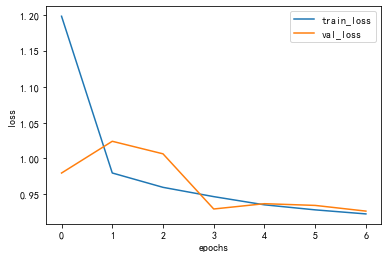

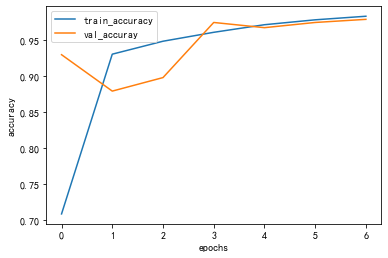

In [ ]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuray = history.history["val_accuracy"]

plt.plot(train_loss,label="train_loss")
plt.plot(val_loss,label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig("loss3.png")
plt.show()


plt.plot(train_accuracy,label="train_accuracy")
plt.plot(val_accuray,label="val_accuray")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig("accuracy3.png")
plt.show()

# 绘制验证集混淆矩阵

In [ ]:
y_pred = model.predict_generator(val_data)
y_pred_classes = np.argmax(y_pred,axis=1)
y_true = list(load_data("val")[1])
matrix = sklearn.metrics.confusion_matrix(load_data("val")[1],y_pred_classes)
print(matrix)

2021-10-15 21:27:54.385675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:27:58.138822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:27:59.928378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:28:05.348266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:28:11.841132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:28:12.068534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:28:20.530268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:28:20.639594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-10-15 21:28:22.277815: W tensorflow/core/lib/png/png_io.cc:88] PNG 

验证集：693
验证集：693
[[132   2   2   2   0]
 [  0 135   1   0   1]
 [  0   2 134   0   0]
 [  0   2   2 127   0]
 [  0   0   0   1 150]]


# 预测并保存到csv

In [ ]:
def preprocess_x(x):
    x = tf.io.read_file(x)
    x = tf.io.decode_jpeg(x,channels=3)
    x = tf.image.resize(x,(224,224))
    x = tf.cast(x,dtype=tf.float32) / 255.
    x = np.expand_dims(x,axis=0)
    return x

In [ ]:
label2name = list(name2label.keys())
print(label2name)
pre_images = []
pre_label = []
for path in glob.glob("./predict/*"):
    pre_images.append(path)
    pre_label.append(label2name[model.predict_classes(preprocess_x(path))[0]])
df = pd.DataFrame({"images":pre_images,"pre_label":pre_label})
df.to_csv("predict.csv",index=False)
df

['mewtwo', 'charmander', 'squirtle', 'bulbasaur', 'pikachu']


2021-10-15 21:29:09.554384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


,images,pre_label
0,./predict/squirtle.png,squirtle
1,./predict/bulbasaur.png,bulbasaur
2,./predict/mewtwo2.png,mewtwo
3,./predict/mewtwo.png,mewtwo
4,./predict/charmander.png,charmander
5,./predict/squirtle1.jpg,squirtle
6,./predict/pikachu1.png,pikachu
7,./predict/charmander1.png,charmander
8,./predict/pikachu.png,pikachu


# 可视化预测结果

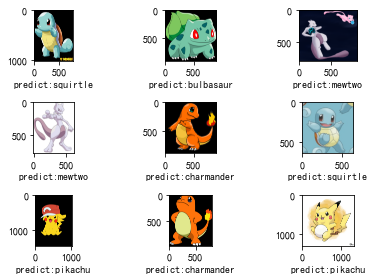

In [ ]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(tf.keras.preprocessing.image.load_img(pre_images[i]))
    plt.xlabel("predict:" + str(pre_label[i]))
plt.tight_layout()  